Crameri-Tackley (2015) model
=======

In [1]:
import networkx as nx
import underworld as uw
import math
from underworld import function as fn
import glucifer
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys
import natsort
import operator
import shutil
from easydict import EasyDict as edict
import collections
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [2]:
#Import the mesh refinement functions
from slippy2 import spmesh, material_graph

In [3]:
############
#Model name.  
############
Model = "T"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

Set physical constants and parameters, including the Rayleigh number (*RA*). 

In [4]:
###########
#Physical parameters
###########


#dimensional parameter dictionary
dp = edict({'LS':2890.*1e3,
           'rho':3300,
           'g':9.81, 
           'eta0':1e23,
           'k':10**-6,
           'a':1.25*10**-5, 
           'TS':300.,
           'TB':2800.,
           'deltaT':2500., 
           'cohesion':1e7, 
           'E':240000., 
           'R':8.314,
           'V':6.34*(10**-7),
           'StALS': 145e3})

#non-dimensional parameter dictionary
RAfac = 1.
ndp = edict({'RA':1e6*RAfac,      
              'LS':1.,
              'eta0':1.,
              'StAeta0':1e-3,
              'k':1.,
              'E':11.55,
              'V':3.0,
              'H':20.,
              'TR':(1600./2500.),
              'TS':(dp.TS/2500.),
              'RD':1.,
              'cohesion':1577.*RAfac,
              'cohesion_reduce':10.,
              'fc':0.1, 
              'low_visc':RAfac*5e-4,
              'up_visc':5e4,
              'random_temp': 0.05})



#A few extra parameters defining lengths scales, mainly effects materal transistions etc.
MANTLETOCRUST = (27.*1e3)/dp.LS #Crust depth
CRUSTTOMANTLE = (300.*1e3)/dp.LS 
LITHTOMANTLE = (660.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (20.*1e3)/dp.LS  #rock-air topography limits
AVGTEMP = 0.53 #Used to define lithosphere


#Compositional Rayliegh number of rock-air
ETAREF = dp.rho*dp.g*dp.a*dp.deltaT*((dp.LS)**3)/(ndp.RA*dp.k) #equivalent dimensional reference viscosity
RC = (3300.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
COMP_RA_FACT = RC/ndp.RA
#Additional dimensionless paramters
ndp["StA"] = ndp.RA*COMP_RA_FACT

In [5]:
###########
#Model / mesh / solver setup parameters
###########
stickyAir = False

#Domain STUFF
MINX = -1.
MINY = 0.
MAXX = 1.0
MAXY = 1.
if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
#MESH STUFF
RES = 48
dim = 2          # number of spatial dimensions
if MINX == 0.:
    Xres = RES
else:
    Xres = 2*RES
if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
else:
    Yres = RES
    MAXY = 1.

periodic = [False, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"
refineMesh = True

#System/Solver stuff
PIC_integration=False

In [6]:
###########
#Model Runtime parameters
###########

swarm_update = 25
swarm_repop = 25
files_output = 1e6
gldbs_output = 25
images_output = 1e6
checkpoint_every = 25
metric_output = 25
sticky_air_temp = 10

comm.Barrier() #Barrier here so no procs run the check in the next cell too early 

assert metric_output <= checkpoint_every, 'Checkpointing should run less or as ofen as metric output'
assert (metric_output >= swarm_update), 'Swarm update is needed before checkpointing'
assert metric_output >= sticky_air_temp, 'Sticky air temp should be updated more frequently that metrics'


## build and Refine mesh

In [7]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)



velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [8]:
#X-Axis

if refineMesh:
    mesh.reset()
    axis = 0
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (abs(mesh.maxCoord[axis]) - abs(mesh.minCoord[axis]))/2.
    el_reduction = 0.6
    dx = mesh.maxCoord[axis] - min_point

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction) *deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'x',norm = 'Min', constraints = [])

Min
(96, 0.012500000000000022, 1.6999999999999993, 0.60000000000000464)
('edges', 96)
-- iteration 0 --
| F( p_n ) |^2: 0.000144675925926
| p_n+1 - p_n |^2: 0.514222608025
-- iteration 1 --
| F( p_n ) |^2: 3.7725958345e-31
Min, Max element width: 
0.01250
0.02917


In [9]:
axis = 1
orgs = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)

value_to_constrain = 1.


yconst = [(spmesh.find_closest(orgs, value_to_constrain), np.array([value_to_constrain,0]))]

In [10]:
#Y-Axis
if refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.6
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = yconst)

Min
(48, 0.012500000000000037, 0.84479166666666661, 0.63404255319149427)
('edges', 48)
-- iteration 0 --
| F( p_n ) |^2: 0.000144799054374
| p_n+1 - p_n |^2: 0.267009456265
-- iteration 1 --
| F( p_n ) |^2: 1.82445751044e-31
Min, Max element width: 
0.01250
0.02917



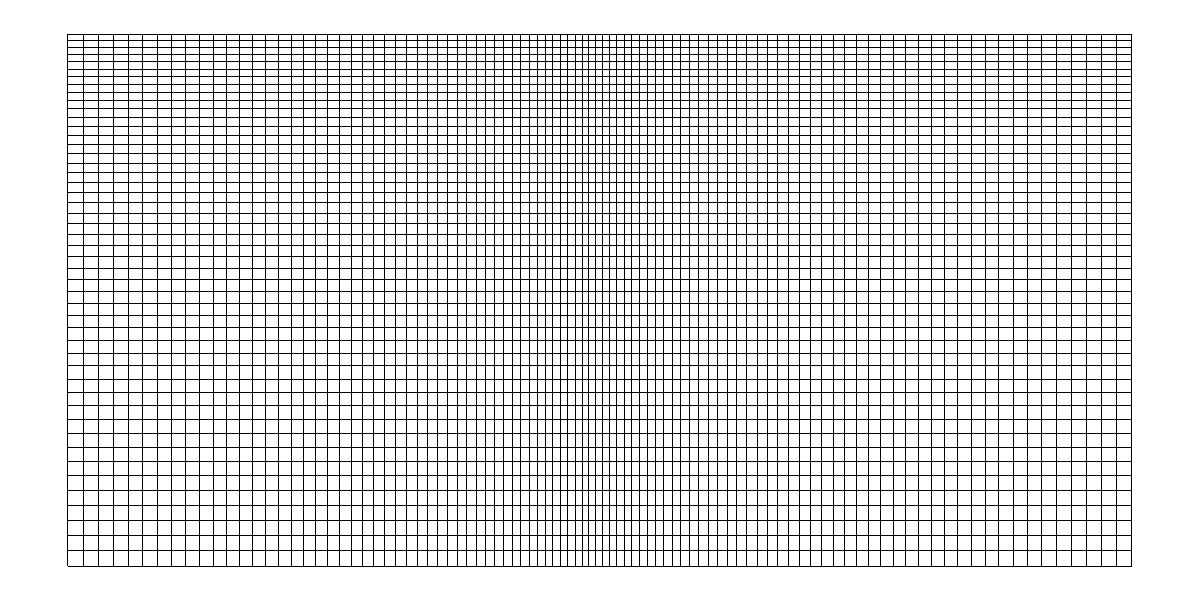

In [11]:
figMesh = glucifer.Figure(figsize=(1200,600))
#figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh) )
figMesh.show()

# ICs and BCs

In [12]:
# send boundary condition information to underworld
IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
TWalls = mesh.specialSets["MaxJ_VertexSet"]
BWalls = mesh.specialSets["MinJ_VertexSet"]
AWalls = IWalls + JWalls

In [13]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

In [14]:
#Create Initial boundary layers, and perturbation (slab)

def wbl(x, w0 = 0.06):
    delx = 1- abs(x)
    Wbl = w0*math.sqrt(delx)
    if Wbl== 0.: #to avoid division by zero
        Wbl = 1e-8
    return Wbl


def tempf(z,w,t0=0.64):
    temp = t0*math.erf((1-z)/w)
    return temp

age_asymmetry = 1. #1 meaning no asymmetry

for index, coord in enumerate(mesh.data):
    if coord[0] > 0.:
        w = wbl(coord[0])
        t = tempf(coord[1], w)
        temperatureField.data[index] = t
    else:
        w = wbl(coord[0])/age_asymmetry
        t = tempf(coord[1], w)
        temperatureField.data[index] = t

for index, coord in enumerate(mesh.data):
    if abs(coord[0]) < wbl(0)/2. and coord[1] > 0.5:
        w = wbl(0)/2.
        d = w - abs(coord[0])
        t = tempf(d, coord[1], w)
        temperatureField.data[index] = t
               

#Set sticky air Temp to zero
for index, coord in enumerate(mesh.data):
    if coord[1] >= 1.:
        temperatureField.data[index] = dp.TS/dp.deltaT

In [15]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (IWalls, JWalls) )

# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(TWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         indexSetsPerDof=BWalls)


# set initial conditions (and boundary values)
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.





In [16]:
#Add Random 125 K temp perturbation

tempNump = temperatureField.data
for index, coord in enumerate(mesh.data):
        pertCoeff = (ndp.random_temp*(np.random.rand(1)[0] - 0.5)) #this should create values between [-0.5,0.5] from uniform dist.
        ict = tempNump[index]
        tempNump[index] = ict + pertCoeff

In [17]:
## Reset bottom Dirichlet conds.
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TR
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TS

## Particles

In [18]:
###########
#Material Swarm and variables
###########

gSwarm = uw.swarm.Swarm(mesh=mesh)
materialVariable = gSwarm.add_variable( dataType="int",count=1 )
rockIntVar = gSwarm.add_variable( dataType="double", count=1 )
airIntVar = gSwarm.add_variable( dataType="double", count=1 )
lithIntVar = gSwarm.add_variable( dataType="double", count=1 )

varlist = [materialVariable, rockIntVar, airIntVar, lithIntVar]
varnames = ['materialVariable', 'rockIntVar', 'airIntVar', 'lithIntVar']

In [19]:
# Initialise swarm variables

mantleIndex = 0
lithosphereIndex = 1
crustIndex = 2
airIndex = 3


layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=25)
# Now use it to populate.
gSwarm.populate_using_layout( layout=layout )

materialVariable.data[:] = mantleIndex
#Set initial air and crust materials (allow the graph to take care of lithsophere)
#########
#for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
#    if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
#             materialVariable.data[particleID] = airIndex
#    elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
#             materialVariable.data[particleID] = crustIndex

# Material Graphs
Materials are stored in a directed Graph, this doesn't really add any efficiency, but provided a consistent data structure to query and modify.

In [20]:
#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

coordinate = fn.input()
depthFn = 1. - coordinate[1]

materialVariable.data[:] = mantleIndex


#Important: All processors need to know about all material types
material_list = [0,1,2,3]


#######Graph object
#DG = nx.DiGraph(field="Depth")
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)

#######Now the edges representing the material transitions

#anything to air
#DG.add_transition((0,3), depthFn, operator.gt, -1*TOPOHEIGHT)
#DG.add_transition((1,3), depthFn, operator.gt, -1*TOPOHEIGHT)
#DG.add_transition((2,3), depthFn, operator.gt, -1*TOPOHEIGHT)



#Anything to mantle
DG.add_transition((2,0), depthFn, operator.gt, CRUSTTOMANTLE)
DG.add_transition((1,0), depthFn, operator.gt, LITHTOMANTLE )



#Anything to lithsphere
DG.add_transition((0,1), depthFn, operator.lt, MANTLETOLITH)
DG.add_transition((0,1), temperatureField, operator.lt, 0.75*AVGTEMP)



#Anything to crust
DG.add_transition((0,3), depthFn, operator.lt, MANTLETOCRUST)
DG.add_transition((1,3), depthFn, operator.lt, MANTLETOCRUST)
DG.add_transition((3,3), depthFn, operator.lt, TOPOHEIGHT)





In [21]:
MANTLETOCRUST

0.009342560553633217

In [22]:
print( temperatureField.evaluate((0.5, 0.98))[0][0] , 0.75*AVGTEMP)
operator.gt(temperatureField.evaluate((0.5, 0.98))[0][0], 0.75*AVGTEMP)

(0.31621118519014185, 0.3975)


False

In [23]:
DG.nodes()

[0, 1, 2, 3]

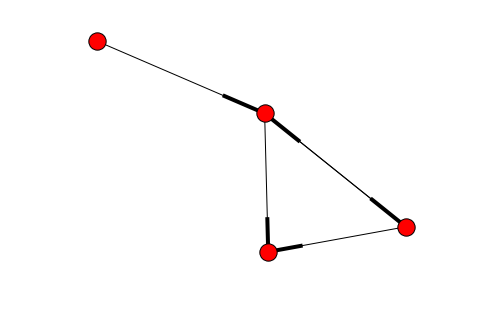

In [24]:
%matplotlib inline
nx.draw(DG,pos=nx.spring_layout(DG), with_label=True, cmap='jet')

In [25]:
#This is out basic call to the swarm_update function. 
#while DG.number_changed != 0:
#    DG.walk_update(gSwarm, materialVariable)

In [26]:
DG.build_condition_list(materialVariable)

In [27]:
#DG.condition_list

In [28]:
%%time
for i in range(2):
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

CPU times: user 5.87 s, sys: 11.1 ms, total: 5.89 s
Wall time: 5.89 s



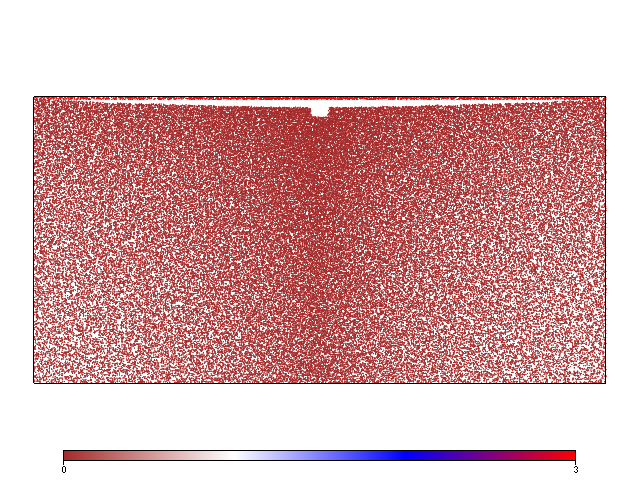

In [29]:
#Pack some stuff into a database as well
fig = glucifer.Figure()
fig.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red', pointSize=2))
#fig.append( glucifer.objects.Surface(mesh, temperatureField))
#fig.save_database('test.gldb')
fig.show()

In [30]:
np.unique(materialVariable.data)

array([0, 1, 3], dtype=int32)

## Set the values for the masking swarms

In [31]:
#Setup up a masking Swarm variable for the integrations.
#These should be rebuilt at same frequency as the metric calcualtions

rockIntVar.data[:] = 0.
notair = np.where(materialVariable.data != airIndex)
rockIntVar.data[notair] = 1.

airIntVar.data[:] = 0.
notrock = np.where(materialVariable.data == airIndex)
airIntVar.data[notrock] = 1.

lithIntVar.data[:] = 0.
islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
lithIntVar.data[islith] = 1.

# Material properties


In the paper, Crameri and Tackley give the dimensionless cohesion as well as the dimensionless yield stress gradient. But the latter is given as a function of dimensionless (lithostatic) pressure, whereas it is easier to use dimensionless depth. Easy, multiply the dimensionless depth by $\rho g D$, divide by the stress scale, $\frac{\eta \kappa}{D^2}$ then use the same dimensionless yeild stress gradient ($\mu$)

In [32]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))




#Determine yield criterion for depth (rather than pressure as given in Crameri)
#Scaling is same as van Heck and Tackley, EPSL, 2011
lithopressuregrad = dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k)

In [33]:
#Check important paramters
print(ndp.E, ndp.V,ndp.TS,ndp.RD, ndp.TR, ndp.cohesion)

(11.55, 3.0, 0.12, 1.0, 0.64, 1577.0)


In [34]:
#ndp.up_visc/ndp.low_visc

In [35]:
############
#Mantle
############

#Linear viscosity
arhennius = fn.misc.min(ndp.up_visc,fn.math.exp(((ndp.E + ndp.V*(1.-coordinate[1]))/
                                         (temperatureField + ndp.TS)) - ((ndp.E + ndp.V*(1.- ndp.RD))/(ndp.TR + ndp.TS))))

#Plastic viscosity 
ys =  ndp.cohesion + (depthFn*ndp.fc*lithopressuregrad)
#ys =  ndp.fc*lithopressuregrad*(30e3/dp.LS) # this is the byerlee strength at 30 km
yss = fn.misc.max(ndp.cohesion, ys)
plasticvisc = yss*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
plastic = fn.misc.max(ndp.low_visc,plasticvisc)
#combine these
mantleviscosityFn = fn.exception.SafeMaths(fn.misc.min(arhennius, plastic))

############
#crust
############
ysc = (ndp.cohesion/ndp.cohesion_reduce) + (depthFn*(ndp.fc/100.)*lithopressuregrad)
#ysc = ys/100.
ycs = fn.misc.max((ndp.cohesion/ndp.cohesion_reduce), ysc)
crustplasticvisc = ycs*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
crustplastic = fn.misc.max(ndp.low_visc,crustplasticvisc) 
#crustviscosityFn = fn.exception.SafeMaths(fn.misc.min(arhennius, crustplastic))
crustviscosityFn = fn.exception.SafeMaths(fn.misc.min(1., crustplastic))

Set up material properties
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

In [36]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StAeta0, 
                                    lithosphereIndex:mantleviscosityFn, 
                                    crustIndex:crustviscosityFn,
                                    mantleIndex:mantleviscosityFn} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StA, 
                                    lithosphereIndex:ndp.RA*temperatureField, 
                                    crustIndex:ndp.RA*temperatureField, 
                                    mantleIndex:ndp.RA*temperatureField} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn

Build the Stokes system, solvers, advection-diffusion
------

Setup linear Stokes system to get the initial velocity.

In [37]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               #swarm         = gSwarm, 
                               conditions    = [freeslipBC,],
                               fn_viscosity   = arhennius, 
                               fn_bodyforce   = buoyancyFn,
                               swarm=gSwarm)


In [38]:
#We do one solve with linear viscosity to get the initial strain rate invariant. 
#This solve step also calculates a 'guess' of the the velocity field based on the linear system, 
#which is used later in the non-linear solver.

solver = uw.systems.Solver(stokesPIC)
# If not doing a restart, do a solve on the non-plastic system
#if not checkpointLoad:
solver.solve()

In [39]:
solver.options

In [40]:
####################
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn
###################

#Set more advanced solver option
#solver.options.main.Q22_pc_type='gkgdiag'
#solver.options.A11.ksp_rtol=1e-2
#solver.options.scr.ksp_rtol=1e-3
#solver.options.A11.ksp_type="cg"
solver.options.scr.use_previous_guess = True
#solver.options.scr.ksp_set_min_it_converge = 1
#solver.options.main.penalty=10.0

solver.options.mg.levels = 3
#solver.options.main.remove_constant_pressure_null_space=True
#solver.options.main.penalty = 1e2

#solver.options.A11.ksp_rtol=1e-4
#solver.options.scr.ksp_rtol=1e-4

solver.options.A11.ksp_monitor=''
solver.options.A11.ksp_converged_reason=''

## Solve non-linear using point iteration

In [41]:
solver.solve(nonLinearIterate=True)

## Create an advective-diffusive system

Setup the system in underworld by flagging the temperature and velocity field variables.

In [42]:
#Create advdiff system

advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 20.0,
                                         fn_diffusivity = 1.0, 
                                         conditions     = [neumannTempBC, dirichTempBC] )



advector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

#Switch particle escape on, this will also trigger the inflow population control 
gSwarm.particleEscape = True

In [44]:
#Pack some stuff into a database as well
figDb = glucifer.Figure()
#figDb.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, arrowHead=0.2, scaling=0.002))
figDb.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Surface(mesh, temperatureField))

Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.


In [45]:
pics = uw.swarm.PICIntegrationSwarm(gSwarm)

In [47]:
checkpointLoad = False

In [49]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
if checkpointLoad:
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[0]
    else:
        realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    #f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

In [50]:
# initialise timer for computation
startMain = time.clock()
# Perform steps
while realtime < 0.05:
#while step < 5:
    #Enter non-linear loop
    print step
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    advector.integrate(dt)
    realtime += dt
    step += 1
    timevals.append(realtime)
    
    ################
    #Update temperature field in the air region
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = dp.TS/dp.deltaT
 
    ################
    #Particle update
    ###############
    if (step % swarm_update == 0) or (step % metric_output == 0): #These updates should be done before any metric output
        materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)
        #Also update those integration swarms
        rockIntVar.data[:] = 0.
        notair = np.where(materialVariable.data != airIndex)
        rockIntVar.data[notair] = 1.
        airIntVar.data[:] = 0.
        notrock = np.where(materialVariable.data == airIndex)
        airIntVar.data[notrock] = 1.
        lithIntVar.data[:] = 0.
        islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
        lithIntVar.data[islith] = 1.
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0) & (writeFiles == True):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        figDb.show()
        figDb.save_database(fullpath)
    ################
    #Also repopulate entire swarm periodically
    ################
    if step % swarm_repop == 0:
        pics.repopulate()
        
f_o.close()
print 'step =',step

0


NameError: name 'writeFiles' is not defined